# Image_Resizer.ipynb


In [5]:
from PIL import Image  # Pillow pt. manipularea imaginilor
import numpy as np
import matplotlib.pyplot as plt

## Citire Imagine de pe SD

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

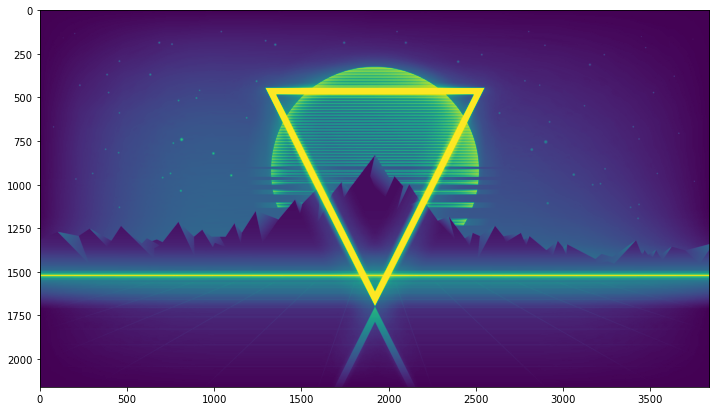

In [26]:
image_path = "/boot/images/image-black-white.jpg"

original_image = Image.open(image_path)

# Conversia imaginii la grayscale (alb-negru)
grayscale_image = original_image.convert("L")

#pt afisare
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = grayscale_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(grayscale_image)

## Transformare imagine in array

In [27]:
image_array = np.array(grayscale_image)
      
print(image_array.shape)       

(2160, 3840)


## Accesare PL

In [45]:
from pynq import Overlay, allocate

overlay_path = "/home/xilinx/pynq/overlays/image_resizer/design_1_V2.3.bit"

overlay = Overlay(overlay_path)

In [36]:
overlay?

##### Send data

In [46]:
dma = overlay.axi_dma_0

In [52]:
import time

buffer_ps_to_pl = allocate(shape=image_array.shape, dtype=np.uint8)
buffer_pl_to_ps = allocate((1080, 1920), dtype=np.uint8)  # pt rezultatul de la PL

np.copyto(buffer_ps_to_pl, image_array)

# masurare timp
start_time_recv = time.time()
print("DMA send transfer started...")
dma.sendchannel.transfer(buffer_ps_to_pl)
print("DMA send transfer completed.")

print("DMA receive transfer started...")
dma.recvchannel.transfer(buffer_pl_to_ps)
dma.sendchannel.wait()  
dma.recvchannel.wait()
print("DMA receive transfer completed.")

end_time_recv = time.time()
recv_transfer_time = end_time_recv - start_time_recv
print(f"PL resize took {recv_transfer_time:.3f} seconds.")

processed_image_array = np.array(buffer_pl_to_ps)

processed_image = Image.fromarray(processed_image_array,'L') # 'L' este pentru imagini alb-negru 

DMA send transfer started...
DMA send transfer completed.
DMA receive transfer started...
DMA receive transfer completed.
DMA transfer took 0.1631 seconds.


In [1]:
print(processed_image.shape)

NameError: name 'processed_image' is not defined

Image size: 1920x1080 pixels.


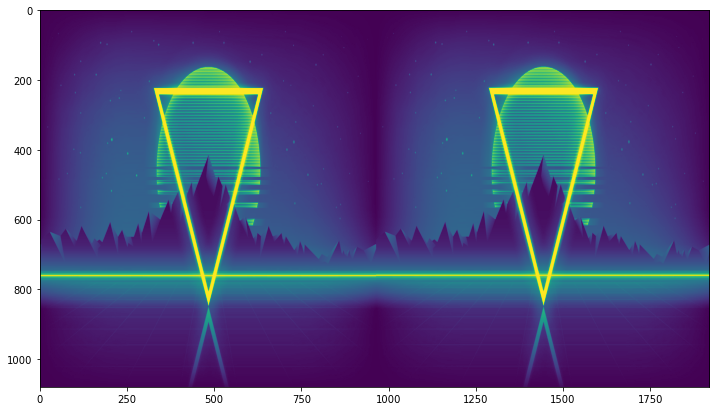

In [48]:
print("Image size: {}x{} pixels.".format(1920, 1080))
plt.figure(figsize=(12, 10));
_ = plt.imshow(processed_image)

 ### Resize facut pe PS   

In [3]:
new_size = (1920, 1080)

img = grayscale_image

start_time = time.time()
resized_img = grayscale_image.resize(new_size)
end_time = time.time()

print(f"PS resize took: {end_time - start_time:.3f} seconds")

<PIL.Image.Image image mode=L size=1280x720 at 0xB3871BF8>


## Write resized image

In [20]:
#calea de salvare
output_path = "/boot/images/image_resized.jpg" 
processed_image.save(output_path)

AttributeError: 'list' object has no attribute '__array_interface__'

### Output image to HDMI

In [ ]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import VideoMode
from PIL import Image
import numpy as np

base = BaseOverlay("base.bit")

# Configurare HDMI 
hdmi_out = base.video.hdmi_out
hdmi_out.configure(VideoMode(1280, 720, 24))  # RFull HD, 24 de biti per pixel
hdmi_out.start()

#image_path = "/boot/images/image-black-white.jpg" 
#image = Image.open(image_path)
image = processed_image

image = image.resize((1280, 720))

# Convertește imaginea în format RGB (dacă este necesar)
#if image.mode != "RGB":
#    image = image.convert("RGB")

# Convertește imaginea într-un array NumPy
image_array = np.array(image)

frame = hdmi_out.newframe()
frame[:, :, :] = image_array


hdmi_out.writeframe(frame)

In [ ]:
# Oprire HDMI 
hdmi_out.stop()
hdmi_out.freebuffer()